In [2]:
import numpy as np 
import sacc
import matplotlib.pyplot as plt
import os
from mflike import MFLike
from cobaya.yaml import yaml_load_file
import camb
import pandas as pd
# %matplotlib inline
col = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
linestyle = ['solid', 'dashed', 'dotted', 'dashdot']
fmt_list = ['o', 'X', '^', 's']

BASE_DIR = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/DR6_fgmodels/"

In [3]:
### data

DIR_data = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/highL_2015/data/"

def to_dl(ell):
    if type(ell) == list:
        ell = np.asarray(ell)
    return ell*(ell+1)/2/np.pi

##ACT-equa data
ells_acte = {}
dls_acte = {}
err_acte = {}

c,nu1,nu2=('tt','acte_148', 'acte_148')
ells_acte[c,nu1,nu2], dls_acte[c,nu1,nu2], err_acte[c,nu1,nu2] = np.loadtxt(
    DIR_data + 'data_act/equa/spectrum_148x148.dat',unpack=True)
c,nu1,nu2=('tt','acte_148', 'acte_220')
ells_acte[c,nu1,nu2], dls_acte[c,nu1,nu2], err_acte[c,nu1,nu2] = np.loadtxt(
    DIR_data + 'data_act/equa/spectrum_148x220.dat',unpack=True)
c,nu1,nu2=('tt','acte_220', 'acte_220')
ells_acte[c,nu1,nu2], dls_acte[c,nu1,nu2], err_acte[c,nu1,nu2] = np.loadtxt(
    DIR_data + 'data_act/equa/spectrum_220x220.dat',unpack=True)
##ACT-south data
ells_acts = {}
dls_acts = {}
err_acts = {}

c,nu1,nu2=('tt','acts_148', 'acts_148')
ells_acts[c,nu1,nu2], dls_acts[c,nu1,nu2], err_acts[c,nu1,nu2] = np.loadtxt(
    DIR_data + 'data_act/south/spectrum_148x148.dat',unpack=True)
c,nu1,nu2=('tt','acts_148', 'acts_220')
ells_acts[c,nu1,nu2], dls_acts[c,nu1,nu2], err_acts[c,nu1,nu2] = np.loadtxt(
    DIR_data + 'data_act/south/spectrum_148x220.dat',unpack=True)
c,nu1,nu2=('tt','acts_220', 'acts_220')
ells_acts[c,nu1,nu2], dls_acts[c,nu1,nu2], err_acts[c,nu1,nu2] = np.loadtxt(
    DIR_data + 'data_act/south/spectrum_220x220.dat',unpack=True)

## to dls
for key, value in ells_acte.items():
    dls_acte[key] = to_dl(value)*dls_acte[key]
    err_acte[key] = to_dl(value)*err_acte[key]
for key, value in ells_acts.items():
    dls_acts[key] = to_dl(value)*dls_acts[key]   
    err_acts[key] = to_dl(value)*err_acts[key] 
    
## SPT george
freqs_spt = ["90x90", "90x150", "90x220", "150x150", "150x220", "220x220"]
freqs_act = ["148x148", "148x218", "218x218"]
fname = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/highL_2015/data/data_spt/spt_bandpower.dat"
df = pd.read_csv(fname, delim_whitespace=True, names=['ells', 'dls', 'err'])
ells_sptg = {}
dls_sptg = {}
err_sptg = {}
split_value = 2106
split_indices = df[df['ells'] == split_value].index
indexes = split_indices.append(pd.Index([df.index[-1]+1]))
split_dataframes = [df.iloc[start:end] for start, end in zip(indexes[:-1], indexes[1:])]
for i, cross in enumerate(freqs_spt):
    fr1, fr2 = cross.split('x')
    nu1, nu2 = [f'sptg_{fr}' for fr in [fr1, fr2]]
    splt = split_dataframes[i]
    ells_sptg['tt', nu1, nu2] = splt['ells'].values
    dls_sptg['tt', nu1, nu2] = splt['dls'].values
    err_sptg['tt', nu1, nu2] = splt['err'].values

## SPT Reichardt
fname = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/DR6_fgmodels/notebooks/Reichardt_bps.dat"
ells_sptr = {}
dls_sptr = {}
err_sptr = {}
names = ['idx',"ells","dls_90x90", "err_90x90", "dls_90x150", "err_90x150",
         "dls_90x220", "err_90x220", "dls_150x150", "err_150x150", 
         "dls_150x220", "err_150x220", "dls_220x220", "err_220x220" ]
df = pd.read_csv(fname, header=0, delim_whitespace=True, names=names)
for i, cross in enumerate(freqs_spt):
    fr1, fr2 = cross.split('x')
    nu1, nu2 = [f'sptr_{fr}' for fr in [fr1, fr2]]
    ells_sptr['tt', nu1, nu2] = df['ells'].values
    dls_sptr['tt', nu1, nu2] = df[f'dls_{cross}'].values
    err_sptr['tt', nu1, nu2] = df[f'err_{cross}'].values
ells_sptr['tt', 'sptr_90', 'sptr_90'] = ells_sptr['tt', 'sptr_90', 'sptr_90'][:-2]
dls_sptr['tt', 'sptr_90', 'sptr_90'] = dls_sptr['tt', 'sptr_90', 'sptr_90'][:-2]
err_sptr['tt', 'sptr_90', 'sptr_90'] = err_sptr['tt', 'sptr_90', 'sptr_90'][:-2]

## ACT DR4 deep
freqs_DR4 = ["98x98", "98x150", "150x150"]
freqs_DR4_write = ["90x90", "90x150", "150x150"]
names = ["ells", "dls_98x98", "err_98x98", "dls_98x150", "err_98x150", "dls_150x150", "err_150x150"]
fname_deep = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/multifreq_spectra_dr4.01/act_dr4.01_multifreq_deep_C_ell_TT.txt"
ells_dr4d = {}
dls_dr4d = {}
err_dr4d = {}
df = pd.read_csv(fname_deep, header=0, delim_whitespace=True, names=names, usecols=(0,1,2,3,4,5,6))
for i, cross in enumerate(freqs_DR4):
    fr1, fr2 = freqs_DR4_write[i].split('x')
    nu1, nu2 = [f'dr4d_{fr}' for fr in [fr1, fr2]]
    ells_dr4d['tt', nu1, nu2] = df['ells'].values
    dls_dr4d['tt', nu1, nu2] = df[f'dls_{cross}'].values
    err_dr4d['tt', nu1, nu2] = df[f'err_{cross}'].values
## to dls
for key, value in ells_dr4d.items():
    dls_dr4d[key] = to_dl(value)*dls_dr4d[key]
    err_dr4d[key] = to_dl(value)*err_dr4d[key]
    
## ACT DR4 wide
freqs_DR4 = ["98x98", "98x150", "150x150"]
names = ["ells", "dls_98x98", "err_98x98", "dls_98x150", "err_98x150", "dls_150x150", "err_150x150"]
fname_wide = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/multifreq_spectra_dr4.01/act_dr4.01_multifreq_wide_C_ell_TT.txt"
ells_dr4w = {}
dls_dr4w = {}
err_dr4w = {}
df = pd.read_csv(fname_wide, header=0, delim_whitespace=True, names=names, usecols=(0,1,2,3,4,5,6))
for i, cross in enumerate(freqs_DR4):
    fr1, fr2 = freqs_DR4_write[i].split('x')
    nu1, nu2 = [f'dr4w_{fr}' for fr in [fr1, fr2]]
    ells_dr4w['tt', nu1, nu2] = df['ells'].values
    dls_dr4w['tt', nu1, nu2] = df[f'dls_{cross}'].values
    err_dr4w['tt', nu1, nu2] = df[f'err_{cross}'].values
## to dls
for key, value in ells_dr4w.items():
    dls_dr4w[key] = to_dl(value)*dls_dr4w[key]
    err_dr4w[key] = to_dl(value)*err_dr4w[key]
    


In [12]:
### defs

def min2params(fname):
    param_dict = {}
    with open(fname, 'r') as file:
        lines = file.readlines()[3:]
        i=0
        fixed=False
        for line in lines:
            i+=1
            parts = line.split()
            if len(parts) >= 3:
                key = parts[2]
                value = parts[1]
                param_dict[key] = float(value)
    return param_dict

def chain2min(chain_name):
    return chain_name+'.minimum'

def chain2like(chain_name):
    yaml_file = chain_name+'.updated.yaml'
    infos = yaml_load_file(yaml_file)
    os.chdir(os.path.join(BASE_DIR, 'DR6_modelling_base','MBAC'))
    return MFLike(infos['likelihood']['mflike.MFLike'])

def read_chi_sqr(fname):
    with open(fname, 'r') as file:
        line = file.readlines()[1]
        chi_sqr = float(line.split('=')[-1])
    return chi_sqr

def cosmo_params(params):
    cosmo_pars = {}
    for key in ["H0","ns", "ombh2", "omch2", "tau"]:
        cosmo_pars[key] = params[key]
    cosmo_pars["logA"] = {"value": params["logA"], "drop": True}
    cosmo_pars["As"] = {"value": "lambda logA: 1e-10*np.exp(logA)"}
    return cosmo_pars

def get_cls_dict(params):
    camb_cosmo = {k: v for k, v in cosmo_params(params).items() if k not in ["logA", "As"]}
    camb_cosmo.update({"As": 1e-10 * np.exp(cosmo_params(params)["logA"]["value"]),"lmax": 6000,"lens_potential_accuracy": 1})
    pars = camb.set_params(**camb_cosmo)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
    cl_dict = {k: powers["total"][:, v] for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}
    cl_dict['tt'][6000:] = 0.
    cl_dict['ell'] = np.linspace(0,6000,6001).astype('int')
    return cl_dict

def get_spectra(param_dict, likelihood):
    cl_dict = get_cls_dict(param_dict)
    Dls = {}
    for s, _ in likelihood.lcuts.items():
        dl = np.zeros_like(likelihood.l_bpws)
        dl[:likelihood.lmax_theory+1] = cl_dict[s][:likelihood.lmax_theory+1]
        Dls[s] = dl
    DlsObs = likelihood.ThFo.get_modified_theory(Dls, **param_dict)
    component_list = likelihood.ThFo.fg_component_list
    fg_dict = likelihood.ThFo._get_foreground_model(**param_dict)
    DlsObs_window = {}
    leff = {}
    for m in likelihood.spec_meta:
        ind = m['ids']
        w = m["bpw"].weight.T
        leff["tt", m["t1"], m["t2"]] = m["leff"]
        DlsObs_window["tt", m["t1"], m["t2"]] = w @ DlsObs["tt", m["t1"], m["t2"]]
    DlsObs_contribution = {}
    for key in component_list.keys():
        exp = key[0]
        cl = key[1]
        for component in component_list[key]:
            for m in likelihood.spec_meta:
                if m["t1"][:4] == exp and m["t2"][:4] == exp:
                    DlsObs_contribution[cl,m["t1"], m["t2"], component] = fg_dict[cl, component, m["t1"],m["t2"]]
    return likelihood.l_bpws, DlsObs, DlsObs_contribution, component_list, leff, DlsObs_window

def get_chi2(param_dict, likelihood):
    cl_dict = get_cls_dict(param_dict)
    Dls = {}
    for s, _ in likelihood.lcuts.items():
        dl = np.zeros_like(likelihood.l_bpws)
        dl[:likelihood.lmax_theory+1] = cl_dict[s][:likelihood.lmax_theory+1]
        Dls[s] = dl
    loglike = likelihood.loglike(cl_dict, **param_dict)
    return -2. * (loglike - likelihood.logp_const)

## Plots all

In [ ]:
### ACT-Equa

fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})
for i, (key, value) in enumerate(ells_acte.items()):
    axs[0, i].errorbar(value, dls_acte[key], yerr=err_acte[key], fmt='o', c='r')
    
chain_list = ['DR4_MBAC_base/outputs/chains/DR4_220_priorcibradio',
              'DR4_MBAC_base/outputs/chains/DR4_priorcibradio',]
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]
label_list = ['DR4 + 220', 'DR4 only']

for i_model in range(len(chain_list)):
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window = get_spectra(params_list[i_model], like_list[i_model])
    for i_spec, (key, value) in enumerate(ells_acte.items()):
        axs[0, i_spec].plot(ell, DlsObs[key], ls=linestyle[i_model], c='k', label=label_list[i_model])
        axs[1, i_spec].errorbar(ells_acte[key], dls_acte[key] - DlsObs_window[key], yerr=err_acte[key], fmt=fmt_list[i_model], c='k', label=label_list[i_model])
        for i_comp, c in enumerate(cmp_list['acte', 'tt']):
            if i_model == 0:
                axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp], label=c)
            else:
                axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp])
                
        
axs[0,1].legend()
axs[1,0].legend()

for i in range(3):
    axs[1, i].set_xlabel('$\ell$', fontsize=20)
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[1, i].set_ylim(-100, 100)
    axs[1, i].set_xlim(2, 12000)
    axs[0, i].set_xlim(2, 12000)
    axs[0,i].set_title(f"{freqs_act[i]}")
    
axs[0,0].set_ylabel('$D_\ell [\mu K^2]$', fontsize=20)
axs[1,0].set_ylabel('$\Delta D_\ell [\mu K^2]$', fontsize=20)
plt.suptitle("ACT-equa")
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/acte.pdf"))
plt.show()


In [ ]:
### ACT-South

fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})
for i, (key, value) in enumerate(ells_acts.items()):
    axs[0, i].errorbar(value, dls_acts[key], yerr=err_acts[key], fmt='o', c='r')
    
chain_list = [#'DR6_modelling_betac-betap-betar/outputs/chains/MBAC_reichardt_T25', 
              'DR6_modelling_betac-betap-betar/outputs/chains/MBAC_prior',
              'DR6_modelling_betac-betap-betar/outputs/chains/MBAC_reichardt_cibp']
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]
label_list = ['MBAC, base', 'MBAC+Reichart, CIBp']

for i_model in range(len(chain_list)):
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window = get_spectra(params_list[i_model], like_list[i_model])
    for i_spec, (key, value) in enumerate(ells_acts.items()):
        axs[0, i_spec].plot(ell, DlsObs[key], ls=linestyle[i_model], c='k', label=label_list[i_model])
        axs[1, i_spec].errorbar(ells_acts[key], dls_acts[key] - DlsObs_window[key], yerr=err_acts[key], fmt=fmt_list[i_model], c='k', label=label_list[i_model])
        for i_comp, c in enumerate(cmp_list['acts', 'tt']):
            if i_model == 0:
                axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp], label=c)
            else:
                axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp])
                
        
axs[0,1].legend()
axs[1,0].legend()

for i in range(3):
    axs[1, i].set_xlabel('$\ell$', fontsize=20)
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[1, i].set_ylim(-100, 100)
    axs[1, i].set_xlim(2, 12000)
    axs[0, i].set_xlim(2, 12000)
    axs[0,i].set_title(f"{freqs_act[i]}")
    
axs[0,0].set_ylabel('$D_\ell [\mu K^2]$', fontsize=20)
axs[1,0].set_ylabel('$\Delta D_\ell [\mu K^2]$', fontsize=20)
plt.suptitle("ACT-south")
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/acts.pdf"))

plt.show()


In [ ]:
### SPT_reichardt (1)

fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})
for i, (key, value) in enumerate(ells_sptr.items()):
    if i<3:
        axs[0, i].errorbar(value, dls_sptr[key], yerr=err_sptr[key], fmt='o', c='r')
    else: pass
    
chain_list = [#'DR6_modelling_betac-betap-betar/outputs/chains/MBAC_reichardt_T25', 
              'DR6_modelling_betac-betap-betar/outputs/chains/reichardt', 
              'DR6_modelling_betac-betap-betar/outputs/chains/MBAC_reichardt_cibp']
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]
label_list = ['reichardt, base', 'MBAC+Reichardt, CIBp']

for i_model in range(len(chain_list)):
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window = get_spectra(params_list[i_model], like_list[i_model])
    for i_spec, (key, value) in enumerate(ells_sptr.items()):
        if i_spec<3:
            axs[0, i_spec].plot(ell, DlsObs[key], ls=linestyle[i_model], c='k', label=label_list[i_model])
            axs[1, i_spec].errorbar(ells_sptr[key], dls_sptr[key] - DlsObs_window[key], yerr=err_sptr[key], fmt=fmt_list[i_model], c='k', label=label_list[i_model])
            for i_comp, c in enumerate(cmp_list['sptr', 'tt']):
                if i_model == 0:
                    axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp], label=c)
                else:
                    axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp])
        else: pass
                
        
axs[0,1].legend()
axs[1,0].legend()

for i in range(3):
    axs[1, i].set_xlabel('$\ell$', fontsize=20)
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[1, i].set_ylim(-100, 100)
    axs[1, i].set_xlim(2, 12000)
    axs[0, i].set_xlim(2, 12000)
    axs[0,i].set_title(f"{freqs_spt[i]}")
    
axs[0,0].set_ylabel('$D_\ell [\mu K^2]$', fontsize=20)
axs[1,0].set_ylabel('$\Delta D_\ell [\mu K^2]$', fontsize=20)
plt.suptitle("SPTr")
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/sptr1.pdf"))

# plt.show()


In [ ]:
### SPT_reichardt (2)

fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})
for i, (key, value) in enumerate(ells_sptr.items()):
    if i>=3:
        axs[0, i-3].errorbar(value, dls_sptr[key], yerr=err_sptr[key], fmt='o', c='r')
    else: pass
    
chain_list = [#'DR6_modelling_betac-betap-betar/outputs/chains/MBAC_reichardt_T25', 
              'DR6_modelling_betac-betap-betar/outputs/chains/reichardt', 
              'DR6_modelling_betac-betap-betar/outputs/chains/MBAC_reichardt_cibp']
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]
label_list = ['reichardt, base', 'MBAC+Reichardt, CIBp']


for i_model in range(len(chain_list)):
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window = get_spectra(params_list[i_model], like_list[i_model])
    for i_spec, (key, value) in enumerate(ells_sptr.items()):
        if i_spec>=3:
            axs[0, i_spec-3].plot(ell, DlsObs[key], ls=linestyle[i_model], c='k', label=label_list[i_model])
            axs[1, i_spec-3].errorbar(ells_sptr[key], dls_sptr[key] - DlsObs_window[key], yerr=err_sptr[key], fmt=fmt_list[i_model], c='k', label=label_list[i_model])
            for i_comp, c in enumerate(cmp_list['sptr', 'tt']):
                if i_model == 0:
                    axs[0, i_spec-3].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp], label=c)
                else:
                    axs[0, i_spec-3].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp])
        else: pass
                
        
axs[0,1].legend()
axs[1,0].legend()

for i in range(3):
    axs[1, i].set_xlabel('$\ell$', fontsize=20)
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[1, i].set_ylim(-100, 100)
    axs[1, i].set_xlim(2, 12000)
    axs[0, i].set_xlim(2, 12000)

    axs[0,i].set_title(f"{freqs_spt[i+3]}")
    
axs[0,0].set_ylabel('$D_\ell [\mu K^2]$', fontsize=20)
axs[1,0].set_ylabel('$\Delta D_\ell [\mu K^2]$', fontsize=20)
plt.suptitle("SPTr")
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/sptr2.pdf"))

# plt.show()


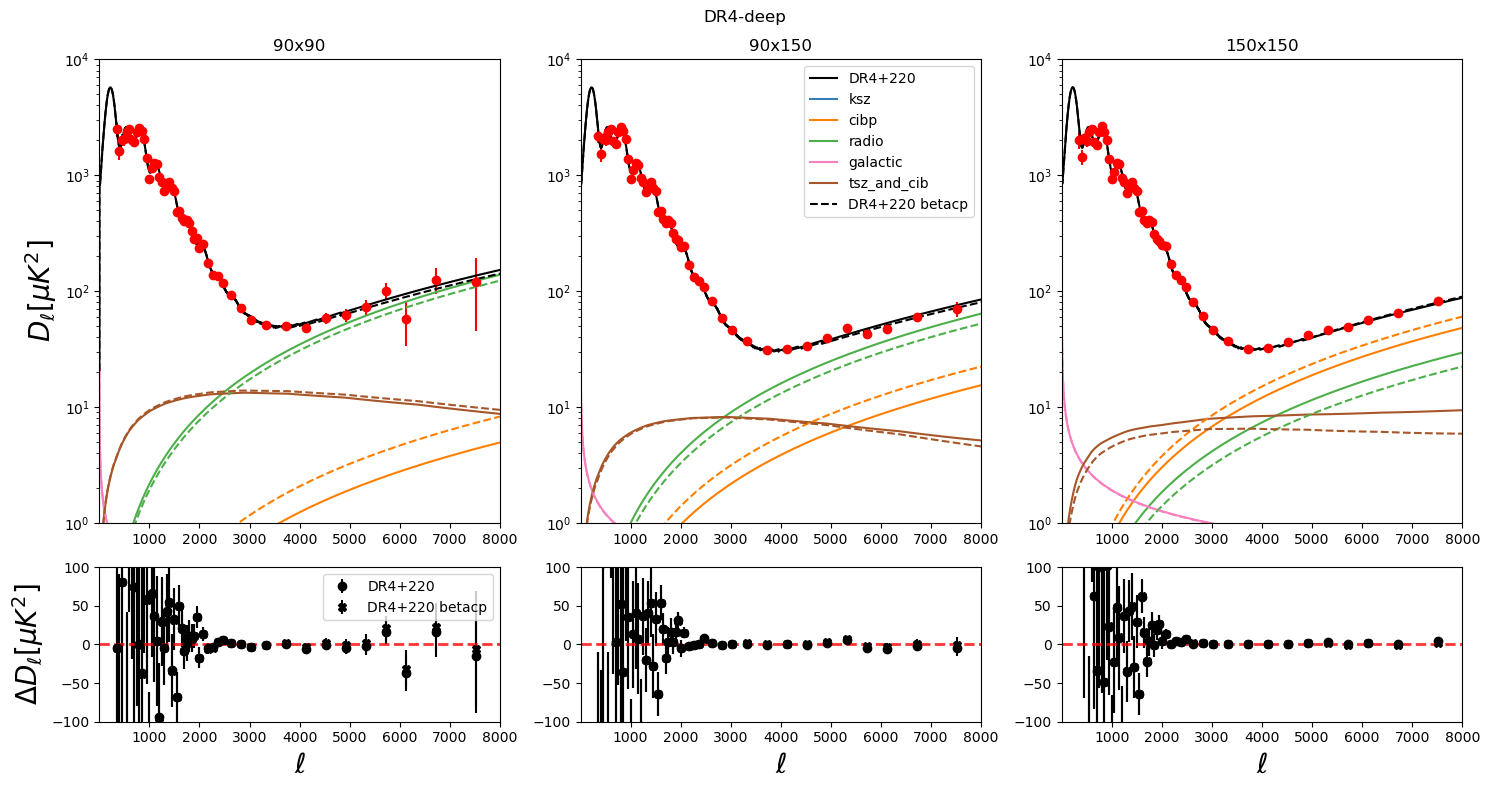

In [21]:
### DR4-deep

fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})
for i, (key, value) in enumerate(ells_dr4d.items()):
    axs[0, i].errorbar(value, dls_dr4d[key], yerr=err_dr4d[key], fmt='o', c='r')
    
chain_list = ['DR4_MBAC_base/outputs/chains/DR4_220',
#               'DR4_MBAC_betac-betap/outputs/chains/DR4_220',
              'DR4_MBAC_betac-betap-betar/outputs/chains/DR4_220',
#               'DR4_MBAC_betar/outputs/chains/DR4_220',
             ]
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]
label_list = ['DR4+220', 'DR4+220 betacp', 'DR4+220 betacpr', 'DR4+220 betar']

for i_model in range(len(chain_list)):
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window = get_spectra(params_list[i_model], like_list[i_model])
    for i_spec, (key, value) in enumerate(ells_dr4d.items()):
        axs[0, i_spec].plot(ell, DlsObs[key], ls=linestyle[i_model], c='k', label=label_list[i_model])
        axs[1, i_spec].errorbar(ells_dr4d[key], dls_dr4d[key] - DlsObs_window[key], yerr=err_dr4d[key], fmt=fmt_list[i_model], c='k', label=label_list[i_model])
        for i_comp, c in enumerate(cmp_list['dr4d', 'tt']):
            if i_model == 0:
                axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp], label=c)
            else:
                axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp])
                
        
axs[0,1].legend()
axs[1,0].legend()

for i in range(3):
    axs[1, i].set_xlabel('$\ell$', fontsize=20)
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[1, i].set_ylim(-100, 100)
    axs[1, i].set_xlim(2, 8000)
    axs[0, i].set_xlim(2, 8000)
    axs[0,i].set_title(f"{freqs_DR4_write[i]}")
    
axs[0,0].set_ylabel('$D_\ell [\mu K^2]$', fontsize=20)
axs[1,0].set_ylabel('$\Delta D_\ell [\mu K^2]$', fontsize=20)
plt.suptitle("DR4-deep")
plt.tight_layout()

# Show the plot
# plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/acte.pdf"))
plt.show()


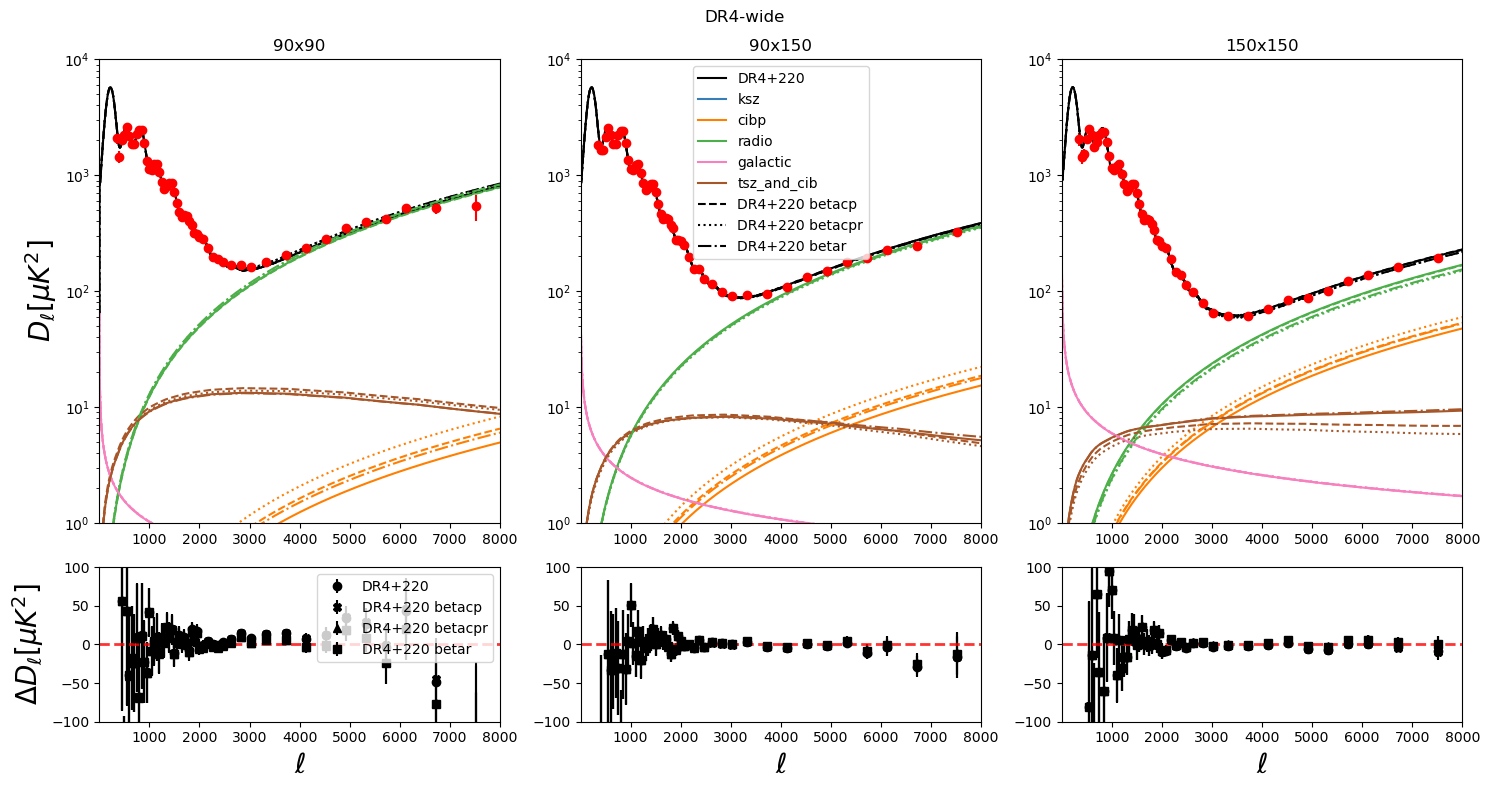

In [7]:
### DR4-wide

fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})
for i, (key, value) in enumerate(ells_dr4w.items()):
    axs[0, i].errorbar(value, dls_dr4w[key], yerr=err_dr4w[key], fmt='o', c='r')
    
chain_list = ['DR4_MBAC_base/outputs/chains/DR4_220',
              'DR4_MBAC_betac-betap/outputs/chains/DR4_220',
              'DR4_MBAC_betac-betap-betar/outputs/chains/DR4_220',
              'DR4_MBAC_betar/outputs/chains/DR4_220',]
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]
label_list = ['DR4+220', 'DR4+220 betacp', 'DR4+220 betacpr', 'DR4+220 betar']

for i_model in range(len(chain_list)):
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window = get_spectra(params_list[i_model], like_list[i_model])
    for i_spec, (key, value) in enumerate(ells_dr4w.items()):
        axs[0, i_spec].plot(ell, DlsObs[key], ls=linestyle[i_model], c='k', label=label_list[i_model])
        axs[1, i_spec].errorbar(ells_dr4w[key], dls_dr4w[key] - DlsObs_window[key], yerr=err_dr4w[key], fmt=fmt_list[i_model], c='k', label=label_list[i_model])
        for i_comp, c in enumerate(cmp_list['dr4d', 'tt']):
            if i_model == 0:
                axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp], label=c)
            else:
                axs[0, i_spec].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp])
                
        
axs[0,1].legend()
axs[1,0].legend()

for i in range(3):
    axs[1, i].set_xlabel('$\ell$', fontsize=20)
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[1, i].set_ylim(-100, 100)
    axs[1, i].set_xlim(2, 8000)
    axs[0, i].set_xlim(2, 8000)
    axs[0,i].set_title(f"{freqs_DR4_write[i]}")
    
axs[0,0].set_ylabel('$D_\ell [\mu K^2]$', fontsize=20)
axs[1,0].set_ylabel('$\Delta D_\ell [\mu K^2]$', fontsize=20)
plt.suptitle("DR4-wide")
plt.tight_layout()

# Show the plot
# plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/acte.pdf"))
plt.show()


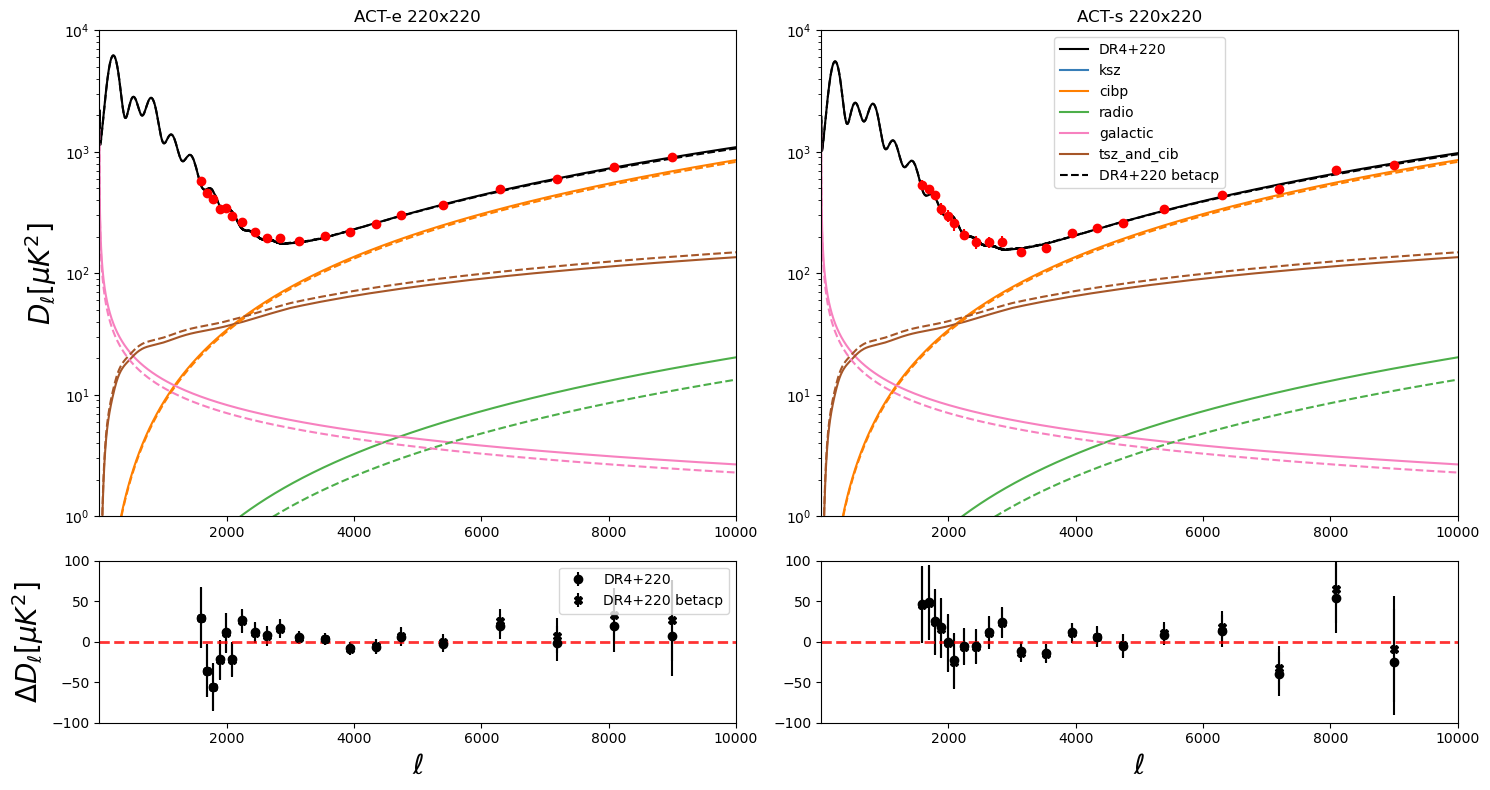

In [23]:
### 220x220

fig, axs = plt.subplots(2, 2, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})
key = ('tt', 'acte_220', 'acte_220')
axs[0, 0].errorbar(ells_acte[key], dls_acte[key], yerr=err_acte[key], fmt='o', c='r')
    
chain_list = ['DR4_MBAC_base/outputs/chains/DR4_220',
#               'DR4_MBAC_betac-betap/outputs/chains/DR4_220',
              'DR4_MBAC_betac-betap-betar/outputs/chains/DR4_220',
#               'DR4_MBAC_betar/outputs/chains/DR4_220',
             ]
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]
label_list = ['DR4+220', 'DR4+220 betacp', 'DR4+220 betacpr', 'DR4+220 betar']

for i_model in range(len(chain_list)):
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window = get_spectra(params_list[i_model], like_list[i_model])
    axs[0, 0].plot(ell, DlsObs[key], ls=linestyle[i_model], c='k', label=label_list[i_model])
    axs[1, 0].errorbar(ells_acte[key], dls_acte[key] - DlsObs_window[key], yerr=err_acte[key], fmt=fmt_list[i_model], c='k', label=label_list[i_model])
    for i_comp, c in enumerate(cmp_list['acte', 'tt']):
        if i_model == 0:
            axs[0, 0].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp], label=c)
        else:
            axs[0, 0].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp])
            
key = ('tt', 'acts_220', 'acts_220')
axs[0, 1].errorbar(ells_acts[key], dls_acts[key], yerr=err_acts[key], fmt='o', c='r')
    
chain_list = ['DR4_MBAC_base/outputs/chains/DR4_220',
#               'DR4_MBAC_betac-betap/outputs/chains/DR4_220',
              'DR4_MBAC_betac-betap-betar/outputs/chains/DR4_220',
#               'DR4_MBAC_betar/outputs/chains/DR4_220',
             ]
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]
label_list = ['DR4+220', 'DR4+220 betacp', 'DR4+220 betacpr', 'DR4+220 betar']

for i_model in range(len(chain_list)):
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window = get_spectra(params_list[i_model], like_list[i_model])
    axs[0, 1].plot(ell, DlsObs[key], ls=linestyle[i_model], c='k', label=label_list[i_model])
    axs[1, 1].errorbar(ells_acts[key], dls_acts[key] - DlsObs_window[key], yerr=err_acts[key], fmt=fmt_list[i_model], c='k', label=label_list[i_model])
    for i_comp, c in enumerate(cmp_list['acts', 'tt']):
        if i_model == 0:
            axs[0, 1].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp], label=c)
        else:
            axs[0, 1].plot(ell, cmp[key+(c,)], ls=linestyle[i_model], c=col[i_comp])
                
        
axs[0,1].legend()
axs[1,0].legend()

for i in range(2):
    axs[1, i].set_xlabel('$\ell$', fontsize=20)
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[1, i].set_ylim(-100, 100)
    axs[1, i].set_xlim(2, 10000)
    axs[0, i].set_xlim(2, 10000)
axs[0,0].set_title("ACT-e 220x220")
axs[0,1].set_title("ACT-s 220x220") 
axs[0,0].set_ylabel('$D_\ell [\mu K^2]$', fontsize=20)
axs[1,0].set_ylabel('$\Delta D_\ell [\mu K^2]$', fontsize=20)
plt.tight_layout()

# Show the plot
# plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/acte.pdf"))
plt.show()


In [19]:
Nbins = 52*3*2 + len(ells_acte['tt','acte_220','acte_220']) + len(ells_acts['tt','acts_220','acts_220'])
dof = Nbins - 12 - np.array([0,1,2,1])

chain_list = ['DR4_MBAC_base/outputs/chains/DR4_220',
              'DR4_MBAC_betac-betap/outputs/chains/DR4_220',
              'DR4_MBAC_betac-betap-betar/outputs/chains/DR4_220',
              'DR4_MBAC_betar/outputs/chains/DR4_220',]
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]


for i, params in enumerate(params_list):
    chi2 = get_chi2(params, like_list[i])
    print(chain_list[i].split('/')[0], ':', chi2, chi2/dof[i])

DR4_MBAC_base : 528.3426563927314 1.5539489893903866
DR4_MBAC_betac-betap : 526.0133515157067 1.551661803881141
DR4_MBAC_betac-betap-betar : 497.1078669294693 1.470733334110856
DR4_MBAC_betar : 503.68290649355004 1.4857902846417406


In [20]:
chain_list = ['DR4_MBAC_base/outputs/chains/DR4_220_priorcibradio',
              'DR4_MBAC_betac-betap/outputs/chains/DR4_220_priorcibradio',
              'DR4_MBAC_betac-betap-betar/outputs/chains/DR4_220_priorcibradio',
              'DR4_MBAC_betar/outputs/chains/DR4_220_priorcibradio',]
params_list = [min2params(chain2min(os.path.join(BASE_DIR, chain))) for chain in chain_list]
like_list = [chain2like(os.path.join(BASE_DIR, chain)) for chain in chain_list]


for i, params in enumerate(params_list):
    chi2 = get_chi2(params, like_list[i])
    print(chain_list[i].split('/')[0], ':', chi2, chi2/dof[i])

DR4_MBAC_base : 529.1788217750236 1.5564082993383048
DR4_MBAC_betac-betap : 526.8590946917138 1.5541566215094804
DR4_MBAC_betac-betap-betar : 499.71482481725434 1.4784462272699832
DR4_MBAC_betar : 503.83067206476517 1.4862261712824931


352